# SYSTEMIC FRAGILITY ANALYSIS 

## Cross-Market Volatility & Early Warning Signals

### Project Overview

This analysis moves beyond traditional single-market forecasting to quantify **systemic financial fragility** by analyzing how volatility transmits across interrelated markets (equities, credit, currencies) and how macroeconomic conditions amplify this transmission. Instead of predicting price movements, we measure the accumulation of systemic tension before it manifests in market crises.

What This Code Provides:

- Multi-asset analysis (ETFs, stocks, synthetic credit/currency)
- GARCH volatility modeling for all assets
- Cross-market correlation analysis
- Volatility transmission networks
- Systemic Fragility Index with early warnings
- Professional 10-panel visualization dashboard
- Comprehensive analysis report

### EXPECTED INSIGHTS & APPLICATIONS
**Systemic Risk Monitoring**
- Real-time fragility assessment for institutional risk management
- Early warning signals for portfolio de-risking decisions
- Regime-aware asset allocation based on systemic conditions

**Policy & Research Applications**
- Central bank monitoring of financial system stability
- Academic research on volatility transmission mechanisms
- Regulatory stress testing of interconnected markets

**Practical Portfolio Management**
- Dynamic hedging strategies triggered by fragility regimes
- Correlation-aware diversification that adapts to market conditions
- Risk budget allocation based on systemic environment

In [1]:
import zipfile
import os
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from arch import arch_model
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# CONFIGURATION

class Config:
    """Configuration parameters for the analysis"""
    # Data parameters
    ZIP_PATH = 'Stock Market.zip'
    EXTRACT_PATH = 'Stock Market'
    ROLLING_WINDOW = 63  # 3 months for rolling calculations
    GARCH_WINDOW = 252   # 1 year for GARCH estimation
    
    # Fragility Index parameters
    VOLATILITY_WEIGHT = 0.35
    CORRELATION_WEIGHT = 0.30
    NETWORK_WEIGHT = 0.25
    MACRO_WEIGHT = 0.10
    
    # Thresholds
    HIGH_FRAGILITY_THRESHOLD = 0.7
    MEDIUM_FRAGILITY_THRESHOLD = 0.4


In [3]:
# DATA LOADING & MULTI-ASSET PREPARATION - FIXED VERSION

def load_data_simple(extract_path):
    """
    Simple robust data loading based on your working previous code
    """
    print("🔄 LOADING DATA...")
    
    etf_folder = os.path.join(extract_path, 'ETFs')
    stocks_folder = os.path.join(extract_path, 'Stocks')
    
    asset_data = {}
    
    # Load ETF samples
    etf_files = [f for f in os.listdir(etf_folder) if f.endswith('.txt')][:8]  # Increased to 8 ETFs
    etf_dfs = []
    for file in etf_files:
        try:
            df = pd.read_csv(os.path.join(etf_folder, file))
            df['Symbol'] = file.replace('.us.txt', '')
            df['Asset_Class'] = 'Equity_ETF'
            df['Date'] = pd.to_datetime(df['Date'])
            etf_dfs.append(df)
            print(f"  ✅ Loaded ETF: {file} ({len(df)} rows)")
        except Exception as e:
            print(f"  ⚠ Could not load {file}: {e}")
    
    if etf_dfs:
        asset_data['Equity_ETFs'] = pd.concat(etf_dfs, ignore_index=True)
    
    # Load Stock samples  
    stock_files = [f for f in os.listdir(stocks_folder) if f.endswith('.txt')][:12]  # Increased to 12 stocks
    stock_dfs = []
    for file in stock_files:
        try:
            df = pd.read_csv(os.path.join(stocks_folder, file))
            df['Symbol'] = file.replace('.us.txt', '')
            df['Asset_Class'] = 'Equity_Stock'
            df['Date'] = pd.to_datetime(df['Date'])
            stock_dfs.append(df)
            print(f"  ✅ Loaded Stock: {file} ({len(df)} rows)")
        except Exception as e:
            print(f"  ⚠ Could not load {file}: {e}")
    
    print(f"✅ Loaded {len(etf_dfs)} ETFs and {len(stock_dfs)} Stocks")
    return asset_data

In [4]:
def create_synthetic_credit_data(dates):
    """
    Create synthetic credit spread data (corporate bonds vs treasuries)
    """
    print("  🔄 Generating synthetic credit data...")
    
    n_periods = len(dates)
    time_index = np.arange(n_periods)
    
    # Base credit spread with economic cycles
    base_spread = 2.0 + 0.5 * np.sin(2 * np.pi * time_index / (365*2))
    
    # Credit crisis spikes
    crisis_spike = 3.0 * np.exp(-0.5 * ((time_index - 1000) / 100) ** 2)
    
    # Random noise
    spread_noise = np.random.normal(0, 0.2, n_periods)
    
    credit_spreads = base_spread + crisis_spike + spread_noise
    
    credit_data = pd.DataFrame({
        'Date': dates,
        'Symbol': 'SYNTH_CREDIT',
        'Asset_Class': 'Credit',
        'Close': credit_spreads,  # Representing spread in percentage points
        'High': credit_spreads + 0.5,
        'Low': np.maximum(credit_spreads - 0.5, 0.1),
        'Open': credit_spreads,
        'Volume': np.random.lognormal(10, 1, n_periods)
    })
    
    return credit_data

def create_synthetic_currency_data(dates):
    """
    Create synthetic currency data (DXY - US Dollar Index)
    """
    print("  🔄 Generating synthetic currency data...")
    
    n_periods = len(dates)
    time_index = np.arange(n_periods)
    
    # Dollar strength cycles
    base_dxy = 95 + 5 * np.sin(2 * np.pi * time_index / (365*3))
    
    # Flight-to-quality spikes
    safety_spikes = 8 * np.exp(-0.5 * ((time_index - 800) / 80) ** 2)
    
    # Random noise
    dxy_noise = np.random.normal(0, 0.5, n_periods)
    
    dxy_values = base_dxy + safety_spikes + dxy_noise
    
    currency_data = pd.DataFrame({
        'Date': dates,
        'Symbol': 'SYNTH_DXY',
        'Asset_Class': 'Currency',
        'Close': dxy_values,
        'High': dxy_values + 1,
        'Low': dxy_values - 1,
        'Open': dxy_values,
        'Volume': np.random.lognormal(12, 1, n_periods)
    })
    
    return currency_data

def prepare_returns_data(asset_data, date_range):
    """
    Prepare clean returns data for all asset classes
    """
    print("🔄 PREPARING RETURNS DATA...")
    
    all_assets = []
    
    # Process real equity data
    for asset_class, df in asset_data.items():
        for symbol in df['Symbol'].unique():
            asset_df = df[df['Symbol'] == symbol].copy()
            asset_df = asset_df.sort_values('Date')
            asset_df['Returns'] = asset_df['Close'].pct_change()
            asset_df = asset_df.dropna(subset=['Returns'])
            all_assets.append(asset_df[['Date', 'Symbol', 'Asset_Class', 'Returns']])
    
    # Add synthetic credit data
    dates = pd.date_range(start=date_range[0], end=date_range[1], freq='D')
    credit_data = create_synthetic_credit_data(dates)
    credit_data['Returns'] = credit_data['Close'].pct_change()
    all_assets.append(credit_data[['Date', 'Symbol', 'Asset_Class', 'Returns']])
    
    # Add synthetic currency data
    currency_data = create_synthetic_currency_data(dates)
    currency_data['Returns'] = currency_data['Close'].pct_change()
    all_assets.append(currency_data[['Date', 'Symbol', 'Asset_Class', 'Returns']])
    
    # Combine all assets
    returns_data = pd.concat(all_assets, ignore_index=True)
    
    print(f"  ✅ Prepared returns data for {returns_data['Symbol'].nunique()} assets")
    print(f"  📊 Asset classes: {returns_data['Asset_Class'].unique()}")
    
    return returns_data

### TIER 1: FOUNDATIONAL VOLATILITY REGIMES
**1. GARCH Volatility Clustering Analysis**

Key Question: How does volatility persist and cluster across different asset classes during stress periods?

- Method: Rolling GARCH(1,1) models capture volatility persistence across equity ETFs, individual stocks, credit spreads, and currencies
- Insight: High volatility persistence indicates markets are "remembering" stress, creating fragile conditions
- Visualization: Multi-asset volatility time series showing contagion patterns

### GARCH VOLATILITY MODELING

In [5]:
def calculate_garch_volatility(returns_series, window=Config.GARCH_WINDOW):
    """
    Calculate rolling GARCH(1,1) volatility for a returns series
    """
    volatilities = []
    dates = []
    
    returns_values = returns_series.dropna()
    
    if len(returns_values) < window + 50:  # Need sufficient data
        return pd.Series([np.nan] * len(returns_series), index=returns_series.index)
    
    for i in range(window, len(returns_values)):
        try:
            # Use rolling window of returns
            window_returns = returns_values.iloc[i-window:i]
            
            # Fit GARCH(1,1) model
            model = arch_model(window_returns, vol='Garch', p=1, q=1, rescale=False)
            fitted_model = model.fit(disp='off', show_warning=False)
            
            # Forecast next period volatility
            forecast = fitted_model.forecast(horizon=1)
            volatility = np.sqrt(forecast.variance.values[-1, 0])
            
            volatilities.append(volatility)
            dates.append(returns_values.index[i])
            
        except Exception as e:
            volatilities.append(np.nan)
            dates.append(returns_values.index[i])
            continue
    
    # Create series with same index as input
    volatility_series = pd.Series(index=returns_series.index, dtype=float)
    for date, vol in zip(dates, volatilities):
        if date in volatility_series.index:
            volatility_series.loc[date] = vol
    
    return volatility_series

def compute_cross_asset_volatilities(returns_data):
    """
    Compute GARCH volatilities for all assets
    """
    print("🔄 COMPUTING GARCH VOLATILITIES...")
    
    volatility_data = []
    
    # Pivot to get returns matrix (assets as columns)
    returns_pivot = returns_data.pivot_table(
        index='Date', columns='Symbol', values='Returns'
    ).ffill().dropna()  # Forward fill and then drop remaining NaNs
    
    # Calculate GARCH volatility for each asset
    for i, symbol in enumerate(returns_pivot.columns):
        print(f"  📈 Processing {symbol} ({i+1}/{len(returns_pivot.columns)})...")
        asset_returns = returns_pivot[symbol]
        
        if len(asset_returns) > Config.GARCH_WINDOW + 50:
            garch_vol = calculate_garch_volatility(asset_returns)
            
            if not garch_vol.isna().all():
                # Convert to DataFrame
                vol_df = garch_vol.reset_index()
                vol_df.columns = ['Date', 'GARCH_Volatility']
                vol_df['Symbol'] = symbol
                vol_df['Asset_Class'] = returns_data[returns_data['Symbol'] == symbol]['Asset_Class'].iloc[0]
                
                volatility_data.append(vol_df)
                print(f"    ✅ Computed volatility for {symbol}")
            else:
                print(f"    ⚠ Could not compute GARCH for {symbol}")
        else:
            print(f"    ⚠ Insufficient data for {symbol}: {len(asset_returns)} periods")
    
    if volatility_data:
        all_volatilities = pd.concat(volatility_data, ignore_index=True)
        print(f"  ✅ Computed GARCH volatilities for {all_volatilities['Symbol'].nunique()} assets")
        return all_volatilities
    else:
        print("  ❌ No GARCH volatilities computed")
        return pd.DataFrame()

**2. Cross-Market Correlation Regimes**

Key Question: Do correlations between equities, credit, and currencies strengthen during systemic stress, reducing diversification benefits?

- Method: Rolling correlation analysis between asset classes with regime detection
- Insight: Rising cross-market correlations signal increased systemic linkage - all assets move together during crises
- Visualization: Dynamic correlation heatmaps and regime transitions

In [6]:
# CROSS-MARKET CORRELATION ANALYSIS

def calculate_rolling_correlations(returns_data, window=Config.ROLLING_WINDOW):
    """
    Calculate rolling correlations between different asset classes
    """
    print("🔄 COMPUTING ROLLING CORRELATIONS...")
    
    # Pivot to matrix format
    returns_matrix = returns_data.pivot_table(
        index='Date', columns='Symbol', values='Returns'
    ).ffill().dropna()
    
    if len(returns_matrix) < window:
        print(f"  ⚠ Insufficient data for rolling correlations. Need {window} periods, have {len(returns_matrix)}")
        return pd.DataFrame()
    
    # Calculate rolling correlation matrix
    rolling_corrs = returns_matrix.rolling(window=window).corr()
    
    # Extract key cross-asset correlations
    correlation_analysis = []
    
    # Get asset class mapping
    asset_classes = returns_data[['Symbol', 'Asset_Class']].drop_duplicates().set_index('Symbol')['Asset_Class']
    
    # Focus on key correlations
    equity_symbols = asset_classes[asset_classes.str.contains('Equity')].index.tolist()
    credit_symbols = asset_classes[asset_classes == 'Credit'].index.tolist()
    currency_symbols = asset_classes[asset_classes == 'Currency'].index.tolist()
    
    for i in range(window, len(returns_matrix)):
        date = returns_matrix.index[i]
        
        try:
            date_corrs = rolling_corrs.loc[date]
            
            if date_corrs is not None and not date_corrs.isna().all().all():
                # Equity-Credit correlation
                eq_credit_corr = np.nan
                if equity_symbols and credit_symbols:
                    try:
                        eq_credit_corr = date_corrs.loc[equity_symbols[0], credit_symbols[0]]
                    except:
                        pass
                
                # Equity-Currency correlation  
                eq_currency_corr = np.nan
                if equity_symbols and currency_symbols:
                    try:
                        eq_currency_corr = date_corrs.loc[equity_symbols[0], currency_symbols[0]]
                    except:
                        pass
                
                # Average correlation across all assets (market connectivity)
                corr_matrix = date_corrs.values
                np.fill_diagonal(corr_matrix, np.nan)
                avg_market_correlation = np.nanmean(corr_matrix)
                
                correlation_analysis.append({
                    'Date': date,
                    'Equity_Credit_Correlation': eq_credit_corr,
                    'Equity_Currency_Correlation': eq_currency_corr,
                    'Average_Market_Correlation': avg_market_correlation
                })
        except Exception as e:
            continue
    
    if correlation_analysis:
        correlation_df = pd.DataFrame(correlation_analysis)
        print("  ✅ Computed rolling cross-market correlations")
        return correlation_df
    else:
        print("  ❌ Could not compute rolling correlations")
        return pd.DataFrame()

**3. Macro-Volatility Transmission**

Key Question: How do monetary policy and inflation regimes affect cross-market volatility patterns?

- Method: Synthetic macroeconomic data integration with volatility modeling
- Insight: Tightening monetary policy often amplifies volatility transmission across markets
- Visualization: Volatility networks colored by macro regimes

In [7]:
# VOLATILITY TRANSMISSION NETWORK

def build_volatility_network(volatility_data, returns_data, window=63):
    """
    Build network of volatility spillovers between assets
    """
    print("🔄 BUILDING VOLATILITY TRANSMISSION NETWORK...")
    
    if volatility_data.empty:
        print("  ⚠ No volatility data available for network analysis")
        return pd.DataFrame()
    
    # Prepare volatility matrix
    vol_matrix = volatility_data.pivot_table(
        index='Date', columns='Symbol', values='GARCH_Volatility'
    ).ffill().dropna()
    
    returns_matrix = returns_data.pivot_table(
        index='Date', columns='Symbol', values='Returns'  
    ).ffill().dropna()
    
    # Align dates
    common_dates = vol_matrix.index.intersection(returns_matrix.index)
    if len(common_dates) < window:
        print(f"  ⚠ Insufficient common dates for network analysis. Need {window}, have {len(common_dates)}")
        return pd.DataFrame()
    
    vol_matrix = vol_matrix.loc[common_dates]
    returns_matrix = returns_matrix.loc[common_dates]
    
    network_metrics = []
    
    for i in range(window, len(common_dates)):
        current_date = common_dates[i]
        
        try:
            # Use rolling window of volatilities
            vol_window = vol_matrix.iloc[i-window:i]
            
            # Calculate volatility correlations (spillover measure)
            vol_correlations = vol_window.corr()
            
            # Create network graph
            G = nx.Graph()
            
            # Add nodes (assets)
            for symbol in vol_correlations.columns:
                asset_class = volatility_data[volatility_data['Symbol'] == symbol]['Asset_Class'].iloc[0]
                G.add_node(symbol, asset_class=asset_class)
            
            # Add edges based on volatility correlations
            for j, sym1 in enumerate(vol_correlations.columns):
                for k, sym2 in enumerate(vol_correlations.columns):
                    if j < k:  # Avoid duplicates and self-loops
                        correlation = abs(vol_correlations.iloc[j, k])
                        if not np.isnan(correlation) and correlation > 0.3:  # Threshold for meaningful connection
                            G.add_edge(sym1, sym2, weight=correlation)
            
            # Calculate network metrics
            if len(G.nodes) > 0:
                network_density = nx.density(G)
                avg_clustering = nx.average_clustering(G)
                
                # Degree centrality (which assets are most connected)
                degree_centrality = nx.degree_centrality(G)
                avg_degree_centrality = np.mean(list(degree_centrality.values())) if degree_centrality else 0
                
                network_metrics.append({
                    'Date': current_date,
                    'Network_Density': network_density,
                    'Avg_Clustering_Coefficient': avg_clustering,
                    'Avg_Degree_Centrality': avg_degree_centrality,
                    'Number_Of_Connections': G.number_of_edges()
                })
                
        except Exception as e:
            continue
    
    if network_metrics:
        network_df = pd.DataFrame(network_metrics)
        print("  ✅ Built volatility transmission network")
        return network_df
    else:
        print("  ❌ Could not build volatility network")
        return pd.DataFrame()

In [8]:
# MACROECONOMIC DATA SYNTHESIS

def create_macroeconomic_data(start_date, end_date):
    """
    Create realistic synthetic macroeconomic data
    """
    print("🔄 GENERATING MACROECONOMIC DATA...")
    
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n_periods = len(dates)
    time_index = np.arange(n_periods)
    
    np.random.seed(42)
    
    # Interest rates with economic cycles
    base_rates = np.linspace(5.0, 1.5, n_periods)
    rate_cycles = 1.0 * np.sin(2 * np.pi * time_index / (365*4))
    fed_funds_rate = base_rates + rate_cycles + np.random.normal(0, 0.1, n_periods)
    
    # Inflation data
    base_inflation = np.linspace(3.0, 2.0, n_periods)
    inflation_spikes = 2.0 * np.exp(-0.5 * ((time_index - 1500) / 200) ** 2)
    cpi = base_inflation + inflation_spikes + np.random.normal(0, 0.2, n_periods)
    
    # Unemployment rate
    base_unemployment = np.linspace(8.0, 4.0, n_periods)
    recession_spike = 4.0 * np.exp(-0.5 * ((time_index - 1000) / 150) ** 2)
    unemployment = base_unemployment + recession_spike + np.random.normal(0, 0.1, n_periods)
    
    # VIX (market fear index)
    base_vix = 15 + 5 * np.sin(2 * np.pi * time_index / 365)
    crisis_spikes = 20 * np.exp(-0.5 * ((time_index - 800) / 50) ** 2)
    vix = base_vix + crisis_spikes + np.random.normal(0, 1, n_periods)
    
    macro_data = pd.DataFrame({
        'Date': dates,
        'Fed_Funds_Rate': fed_funds_rate,
        'CPI_Inflation': cpi,
        'Unemployment_Rate': unemployment,
        'VIX': vix
    })
    
    # Add macro regimes
    macro_data['Monetary_Regime'] = np.where(
        macro_data['Fed_Funds_Rate'].diff() < -0.1, 'Easing',
        np.where(macro_data['Fed_Funds_Rate'].diff() > 0.1, 'Tightening', 'Neutral')
    )
    
    macro_data['Inflation_Regime'] = np.where(
        macro_data['CPI_Inflation'] > 3.5, 'High_Inflation',
        np.where(macro_data['CPI_Inflation'] < 1.5, 'Low_Inflation', 'Moderate_Inflation')
    )
    
    print("  ✅ Generated synthetic macroeconomic data")
    return macro_data


### TIER 2: VOLATILITY TRANSMISSION NETWORKS
**4. Systemic Connectivity Mapping**

Key Question: Which assets become central volatility transmitters during stress periods?

- Method: Network analysis of volatility spillovers using correlation-based graphs
- Insight: High network density indicates increased systemic vulnerability to shocks
- Metrics: Network density, centrality measures, clustering coefficients

In [9]:
# SYSTEMIC FRAGILITY INDEX

def compute_systemic_fragility_index(volatility_data, correlation_data, network_data, macro_data):
    """
    Compute composite Systemic Fragility Index by combining multiple signals
    """
    print("🔄 COMPUTING SYSTEMIC FRAGILITY INDEX...")
    
    if volatility_data.empty or correlation_data.empty:
        print("  ❌ Insufficient data for fragility index computation")
        return pd.DataFrame()
    
    # Prepare components
    fragility_components = []
    
    # 1. Volatility Component - Average GARCH volatility across assets
    avg_volatility = volatility_data.groupby('Date')['GARCH_Volatility'].mean().reset_index()
    avg_volatility.columns = ['Date', 'Avg_Volatility']
    fragility_components.append(avg_volatility)
    
    # 2. Correlation Component - Strength of cross-market correlations
    correlation_strength = correlation_data[['Date', 'Average_Market_Correlation']].copy()
    correlation_strength['Correlation_Strength'] = abs(correlation_strength['Average_Market_Correlation'])
    fragility_components.append(correlation_strength[['Date', 'Correlation_Strength']])
    
    # 3. Network Component - Density of volatility transmission network
    if not network_data.empty:
        network_component = network_data[['Date', 'Network_Density', 'Avg_Degree_Centrality']].copy()
        network_component['Network_Connectivity'] = (network_component['Network_Density'] + network_component['Avg_Degree_Centrality']) / 2
        fragility_components.append(network_component[['Date', 'Network_Connectivity']])
    else:
        # Create dummy network data if not available
        network_dates = correlation_data['Date'].unique()
        network_component = pd.DataFrame({
            'Date': network_dates,
            'Network_Connectivity': np.random.uniform(0.1, 0.5, len(network_dates))
        })
        fragility_components.append(network_component)
        print("  ⚠ Using simulated network data")
    
    # 4. Macro Component - VIX as fear gauge
    macro_component = macro_data[['Date', 'VIX']].copy()
    macro_component['Macro_Stress'] = macro_component['VIX'] / 50  # Normalize to 0-1 range
    fragility_components.append(macro_component[['Date', 'Macro_Stress']])
    
    # Merge all components
    fragility_df = fragility_components[0]
    for component in fragility_components[1:]:
        fragility_df = fragility_df.merge(component, on='Date', how='inner')
    
    # Normalize each component to 0-1 scale
    components_to_scale = ['Avg_Volatility', 'Correlation_Strength', 'Network_Connectivity', 'Macro_Stress']
    
    for component in components_to_scale:
        if component in fragility_df.columns:
            # Min-max normalization
            min_val = fragility_df[component].min()
            max_val = fragility_df[component].max()
            if max_val > min_val:  # Avoid division by zero
                fragility_df[f'{component}_Norm'] = (fragility_df[component] - min_val) / (max_val - min_val)
            else:
                fragility_df[f'{component}_Norm'] = 0.5  # Default value
    
    # Compute weighted fragility index
    fragility_df['Fragility_Index'] = (
        Config.VOLATILITY_WEIGHT * fragility_df['Avg_Volatility_Norm'] +
        Config.CORRELATION_WEIGHT * fragility_df['Correlation_Strength_Norm'] + 
        Config.NETWORK_WEIGHT * fragility_df['Network_Connectivity_Norm'] +
        Config.MACRO_WEIGHT * fragility_df['Macro_Stress_Norm']
    )
    
    # Add fragility regimes
    fragility_df['Fragility_Regime'] = np.where(
        fragility_df['Fragility_Index'] >= Config.HIGH_FRAGILITY_THRESHOLD, 'High_Fragility',
        np.where(fragility_df['Fragility_Index'] >= Config.MEDIUM_FRAGILITY_THRESHOLD, 'Medium_Fragility', 'Low_Fragility')
    )
    
    print("  ✅ Computed Systemic Fragility Index")
    
    return fragility_df

**5. Early Warning Network Signals**

Key Question: Can changes in volatility network structure predict systemic events?

- Method: Monitor network metrics for regime shifts before market drawdowns
- Insight: Sudden increases in network connectivity often precede market stress
- Visualization: Network topology changes over time

In [10]:
# VISUALIZATION & ANALYSIS

def create_comprehensive_visualizations(returns_data, volatility_data, correlation_data, 
                                     network_data, fragility_data, macro_data):
    """
    Create comprehensive visualizations for systemic fragility analysis
    """
    print("📊 CREATING COMPREHENSIVE VISUALIZATIONS...")
    
    plt.style.use('default')
    fig = plt.figure(figsize=(20, 25))
    
    # 1. Systemic Fragility Index Over Time
    plt.subplot(5, 2, 1)
    plt.plot(fragility_data['Date'], fragility_data['Fragility_Index'], 
             color='red', linewidth=2, label='Fragility Index')
    plt.axhline(y=Config.HIGH_FRAGILITY_THRESHOLD, color='darkred', linestyle='--', 
                alpha=0.7, label='High Fragility Threshold')
    plt.axhline(y=Config.MEDIUM_FRAGILITY_THRESHOLD, color='orange', linestyle='--', 
                alpha=0.7, label='Medium Fragility Threshold')
    plt.fill_between(fragility_data['Date'], fragility_data['Fragility_Index'], 
                    alpha=0.3, color='red')
    plt.ylabel('Systemic Fragility Index')
    plt.title('Systemic Financial Fragility Over Time', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 2. Fragility Index Components
    plt.subplot(5, 2, 2)
    components = ['Avg_Volatility_Norm', 'Correlation_Strength_Norm', 
                  'Network_Connectivity_Norm', 'Macro_Stress_Norm']
    component_names = ['Volatility', 'Correlation', 'Network', 'Macro Stress']
    
    for i, component in enumerate(components):
        if component in fragility_data.columns:
            plt.plot(fragility_data['Date'], fragility_data[component], 
                    label=component_names[i], linewidth=1.5, alpha=0.8)
    
    plt.ylabel('Normalized Components (0-1)')
    plt.title('Fragility Index Components', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 3. Cross-Market Correlations
    plt.subplot(5, 2, 3)
    if not correlation_data.empty:
        if 'Equity_Credit_Correlation' in correlation_data.columns:
            plt.plot(correlation_data['Date'], correlation_data['Equity_Credit_Correlation'],
                    label='Equity-Credit Correlation', linewidth=2)
        if 'Equity_Currency_Correlation' in correlation_data.columns:
            plt.plot(correlation_data['Date'], correlation_data['Equity_Currency_Correlation'],
                    label='Equity-Currency Correlation', linewidth=2)
        if 'Average_Market_Correlation' in correlation_data.columns:
            plt.plot(correlation_data['Date'], correlation_data['Average_Market_Correlation'],
                    label='Average Market Correlation', linewidth=2, color='black', linestyle='--')
    plt.ylabel('Rolling Correlation')
    plt.title('Cross-Market Correlation Dynamics', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 4. Volatility Network Density
    plt.subplot(5, 2, 4)
    if not network_data.empty and 'Network_Density' in network_data.columns:
        plt.plot(network_data['Date'], network_data['Network_Density'],
                color='purple', linewidth=2)
    plt.ylabel('Network Density')
    plt.title('Volatility Transmission Network Density', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 5. GARCH Volatilities by Asset Class
    plt.subplot(5, 2, 5)
    if not volatility_data.empty:
        for asset_class in volatility_data['Asset_Class'].unique():
            asset_vol = volatility_data[volatility_data['Asset_Class'] == asset_class]
            avg_vol = asset_vol.groupby('Date')['GARCH_Volatility'].mean()
            if len(avg_vol) > 0:
                plt.plot(avg_vol.index, avg_vol.values, label=asset_class, linewidth=1.5)
    
    plt.ylabel('GARCH Volatility')
    plt.title('Volatility by Asset Class', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 6. Macroeconomic Conditions
    plt.subplot(5, 2, 6)
    plt.plot(macro_data['Date'], macro_data['VIX'], label='VIX', linewidth=2)
    plt.plot(macro_data['Date'], macro_data['CPI_Inflation'], label='CPI Inflation', linewidth=2)
    plt.ylabel('Level')
    plt.title('Macroeconomic Stress Indicators', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # 7. Fragility Regime Analysis
    plt.subplot(5, 2, 7)
    if 'Fragility_Regime' in fragility_data.columns:
        regimes = fragility_data['Fragility_Regime'].value_counts()
        colors = ['green' if 'Low' in str(x) else 'orange' if 'Medium' in str(x) else 'red' for x in regimes.index]
        plt.bar(regimes.index, regimes.values, color=colors)
        plt.ylabel('Number of Periods')
        plt.title('Fragility Regime Distribution', fontsize=14, fontweight='bold')
    
    # 8. Recent Correlation Structure
    plt.subplot(5, 2, 8)
    if not correlation_data.empty:
        recent_date = correlation_data['Date'].max()
        recent_corr = correlation_data[correlation_data['Date'] == recent_date]
        
        if len(recent_corr) > 0:
            corr_metrics = []
            labels = []
            
            if 'Equity_Credit_Correlation' in recent_corr.columns:
                corr_metrics.append(recent_corr['Equity_Credit_Correlation'].iloc[0])
                labels.append('Eq-Credit')
            if 'Equity_Currency_Correlation' in recent_corr.columns:
                corr_metrics.append(recent_corr['Equity_Currency_Correlation'].iloc[0])
                labels.append('Eq-Currency')
            if 'Average_Market_Correlation' in recent_corr.columns:
                corr_metrics.append(recent_corr['Average_Market_Correlation'].iloc[0])
                labels.append('Avg Market')
            
            if corr_metrics:
                plt.bar(range(len(corr_metrics)), corr_metrics, 
                       color=['blue', 'green', 'red'][:len(corr_metrics)])
                plt.xticks(range(len(corr_metrics)), labels, rotation=45)
                plt.ylabel('Correlation')
                plt.title(f'Recent Cross-Market Correlations\n{recent_date.strftime("%Y-%m-%d")}', 
                         fontsize=14, fontweight='bold')
    
    # 9. Component Weights
    plt.subplot(5, 2, 9)
    weights = [Config.VOLATILITY_WEIGHT, Config.CORRELATION_WEIGHT, 
               Config.NETWORK_WEIGHT, Config.MACRO_WEIGHT]
    labels = ['Volatility', 'Correlation', 'Network', 'Macro']
    
    plt.pie(weights, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Fragility Index Component Weights', fontsize=14, fontweight='bold')
    
    # 10. Early Warning Performance
    plt.subplot(5, 2, 10)
    if 'Fragility_Regime' in fragility_data.columns:
        high_fragility_periods = fragility_data[fragility_data['Fragility_Regime'] == 'High_Fragility']
        
        if len(high_fragility_periods) > 0:
            plt.scatter(range(len(high_fragility_periods)), 
                       high_fragility_periods['Fragility_Index'].values,
                       color='red', s=50, alpha=0.7)
            plt.axhline(y=Config.HIGH_FRAGILITY_THRESHOLD, color='darkred', linestyle='--')
            plt.ylabel('Fragility Index')
            plt.title('High Fragility Periods\n(Potential Early Warnings)', 
                     fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return fig



### TIER 3: COMPOSITE FRAGILITY INDEX
**6. Multi-Dimensional Fragility Scoring**

Key Question: How can we combine multiple fragility signals into a single early warning indicator?

Components:

- Volatility Component (35%): Average GARCH volatility across assets
- Correlation Component (30%): Strength of cross-market linkages
- Network Component (25%): Density of volatility transmission
- Macro Component (10%): VIX and economic stress indicators

**7. Fragility Regime Detection**

Key Question: Can we identify distinct fragility states (Low/Medium/High) that predict market stress?

Thresholds:

- High Fragility: Index > 0.7 - Immediate caution warranted
- Medium Fragility: Index 0.4-0.7 - Elevated monitoring required
- Low Fragility: Index < 0.4 - System appears stable
- Validation: Compare fragility regimes with subsequent market drawdowns

In [11]:
def generate_analysis_report(fragility_data, returns_data):
    """
    Generate comprehensive analysis report with key insights
    """
    print("\n" + "="*70)
    print("📈 SYSTEMIC FRAGILITY ANALYSIS REPORT")
    print("="*70)
    
    if fragility_data.empty:
        print("❌ No fragility data available for report")
        return
    
    # Key statistics
    avg_fragility = fragility_data['Fragility_Index'].mean()
    max_fragility = fragility_data['Fragility_Index'].max()
    high_fragility_periods = len(fragility_data[fragility_data['Fragility_Regime'] == 'High_Fragility'])
    total_periods = len(fragility_data)
    
    print(f"\n📊 KEY STATISTICS:")
    print(f"   • Average Fragility Index: {avg_fragility:.3f}")
    print(f"   • Maximum Fragility Index: {max_fragility:.3f}")
    print(f"   • High Fragility Periods: {high_fragility_periods} ({high_fragility_periods/total_periods:.1%})")
    print(f"   • Analysis Period: {fragility_data['Date'].min().strftime('%Y-%m-%d')} to {fragility_data['Date'].max().strftime('%Y-%m-%d')}")
    
    # Regime analysis
    if 'Fragility_Regime' in fragility_data.columns:
        regime_counts = fragility_data['Fragility_Regime'].value_counts()
        print(f"\n🎯 FRAGILITY REGIMES:")
        for regime, count in regime_counts.items():
            percentage = count / total_periods
            print(f"   • {regime}: {count} periods ({percentage:.1%})")
    
    # Early warning insights
    recent_fragility = fragility_data['Fragility_Index'].iloc[-1]
    recent_regime = fragility_data['Fragility_Regime'].iloc[-1] if 'Fragility_Regime' in fragility_data.columns else 'Unknown'
    
    print(f"\n🔍 CURRENT ASSESSMENT:")
    print(f"   • Current Fragility Index: {recent_fragility:.3f}")
    print(f"   • Current Regime: {recent_regime}")
    
    if recent_regime == 'High_Fragility':
        print("   ⚠️  WARNING: System currently in high fragility state")
    elif recent_regime == 'Medium_Fragility':
        print("   🔶 CAUTION: Elevated fragility levels detected")
    else:
        print("   ✅ System appears stable")
    
    # Component analysis
    components = ['Avg_Volatility_Norm', 'Correlation_Strength_Norm', 
                  'Network_Connectivity_Norm', 'Macro_Stress_Norm']
    component_names = ['Volatility', 'Correlation', 'Network', 'Macro Stress']
    
    available_components = [comp for comp in components if comp in fragility_data.columns]
    if available_components:
        recent_components = fragility_data[available_components].iloc[-1]
        dominant_idx = np.argmax(recent_components.values)
        dominant_component = component_names[components.index(available_components[dominant_idx])]
        
        print(f"\n📈 DOMINANT FRAGILITY DRIVER:")
        print(f"   • Primary Contributor: {dominant_component}")
        
        for i, comp in enumerate(available_components):
            value = recent_components.iloc[i]
            comp_name = component_names[components.index(comp)]
            print(f"   • {comp_name}: {value:.3f}")
    
    print(f"\n💡 KEY INSIGHTS:")
    print("   • Rising cross-market correlations often precede systemic stress")
    print("   • High network density indicates increased volatility transmission risk") 
    print("   • Fragility tends to accumulate before manifesting in market drawdowns")
    print("   • Multi-asset analysis provides earlier warnings than single-market views")

### TIER 4: STRATEGIC RISK MANAGEMENT APPLICATIONS
**8. Dynamic Portfolio Hedging**

Key Question: How can fragility signals inform tactical risk management?

- Application: Increase hedging or reduce leverage during high fragility regimes
- Benefit: Avoid being "all-in" during periods of elevated systemic risk
- Evidence: Historical analysis of fragility peaks vs. market crashes

**9. Cross-Asset Diversification Efficacy**

Key Question: Does traditional diversification fail during high fragility periods?

- Analysis: Test correlation breakdowns during fragility spikes
- Insight: High fragility often means "everything correlates," reducing diversification benefits
- Strategy: Adjust diversification assumptions based on current fragility regime

🚀 INITIATING SYSTEMIC FRAGILITY ANALYSIS
🔄 LOADING DATA...
  ✅ Loaded ETF: aadr.us.txt (1565 rows)
  ✅ Loaded ETF: aaxj.us.txt (2325 rows)
  ✅ Loaded ETF: acim.us.txt (1232 rows)
  ✅ Loaded ETF: actx.us.txt (272 rows)
  ✅ Loaded ETF: acwf.us.txt (403 rows)
  ✅ Loaded ETF: acwi.us.txt (2425 rows)
  ✅ Loaded ETF: acwv.us.txt (1491 rows)
  ✅ Loaded ETF: acwx.us.txt (2424 rows)
  ✅ Loaded Stock: a.us.txt (4521 rows)
  ✅ Loaded Stock: aa.us.txt (12074 rows)
  ✅ Loaded Stock: aaap.us.txt (505 rows)
  ✅ Loaded Stock: aaba.us.txt (5434 rows)
  ✅ Loaded Stock: aac.us.txt (785 rows)
  ✅ Loaded Stock: aal.us.txt (989 rows)
  ✅ Loaded Stock: aamc.us.txt (1211 rows)
  ✅ Loaded Stock: aame.us.txt (2926 rows)
  ✅ Loaded Stock: aan.us.txt (3201 rows)
  ✅ Loaded Stock: aaoi.us.txt (1041 rows)
  ✅ Loaded Stock: aaon.us.txt (3201 rows)
  ✅ Loaded Stock: aap.us.txt (3201 rows)
✅ Loaded 8 ETFs and 12 Stocks

📅 Analysis Period: 2008-03-28 to 2017-11-10
🔄 PREPARING RETURNS DATA...
  🔄 Generating synthetic cr

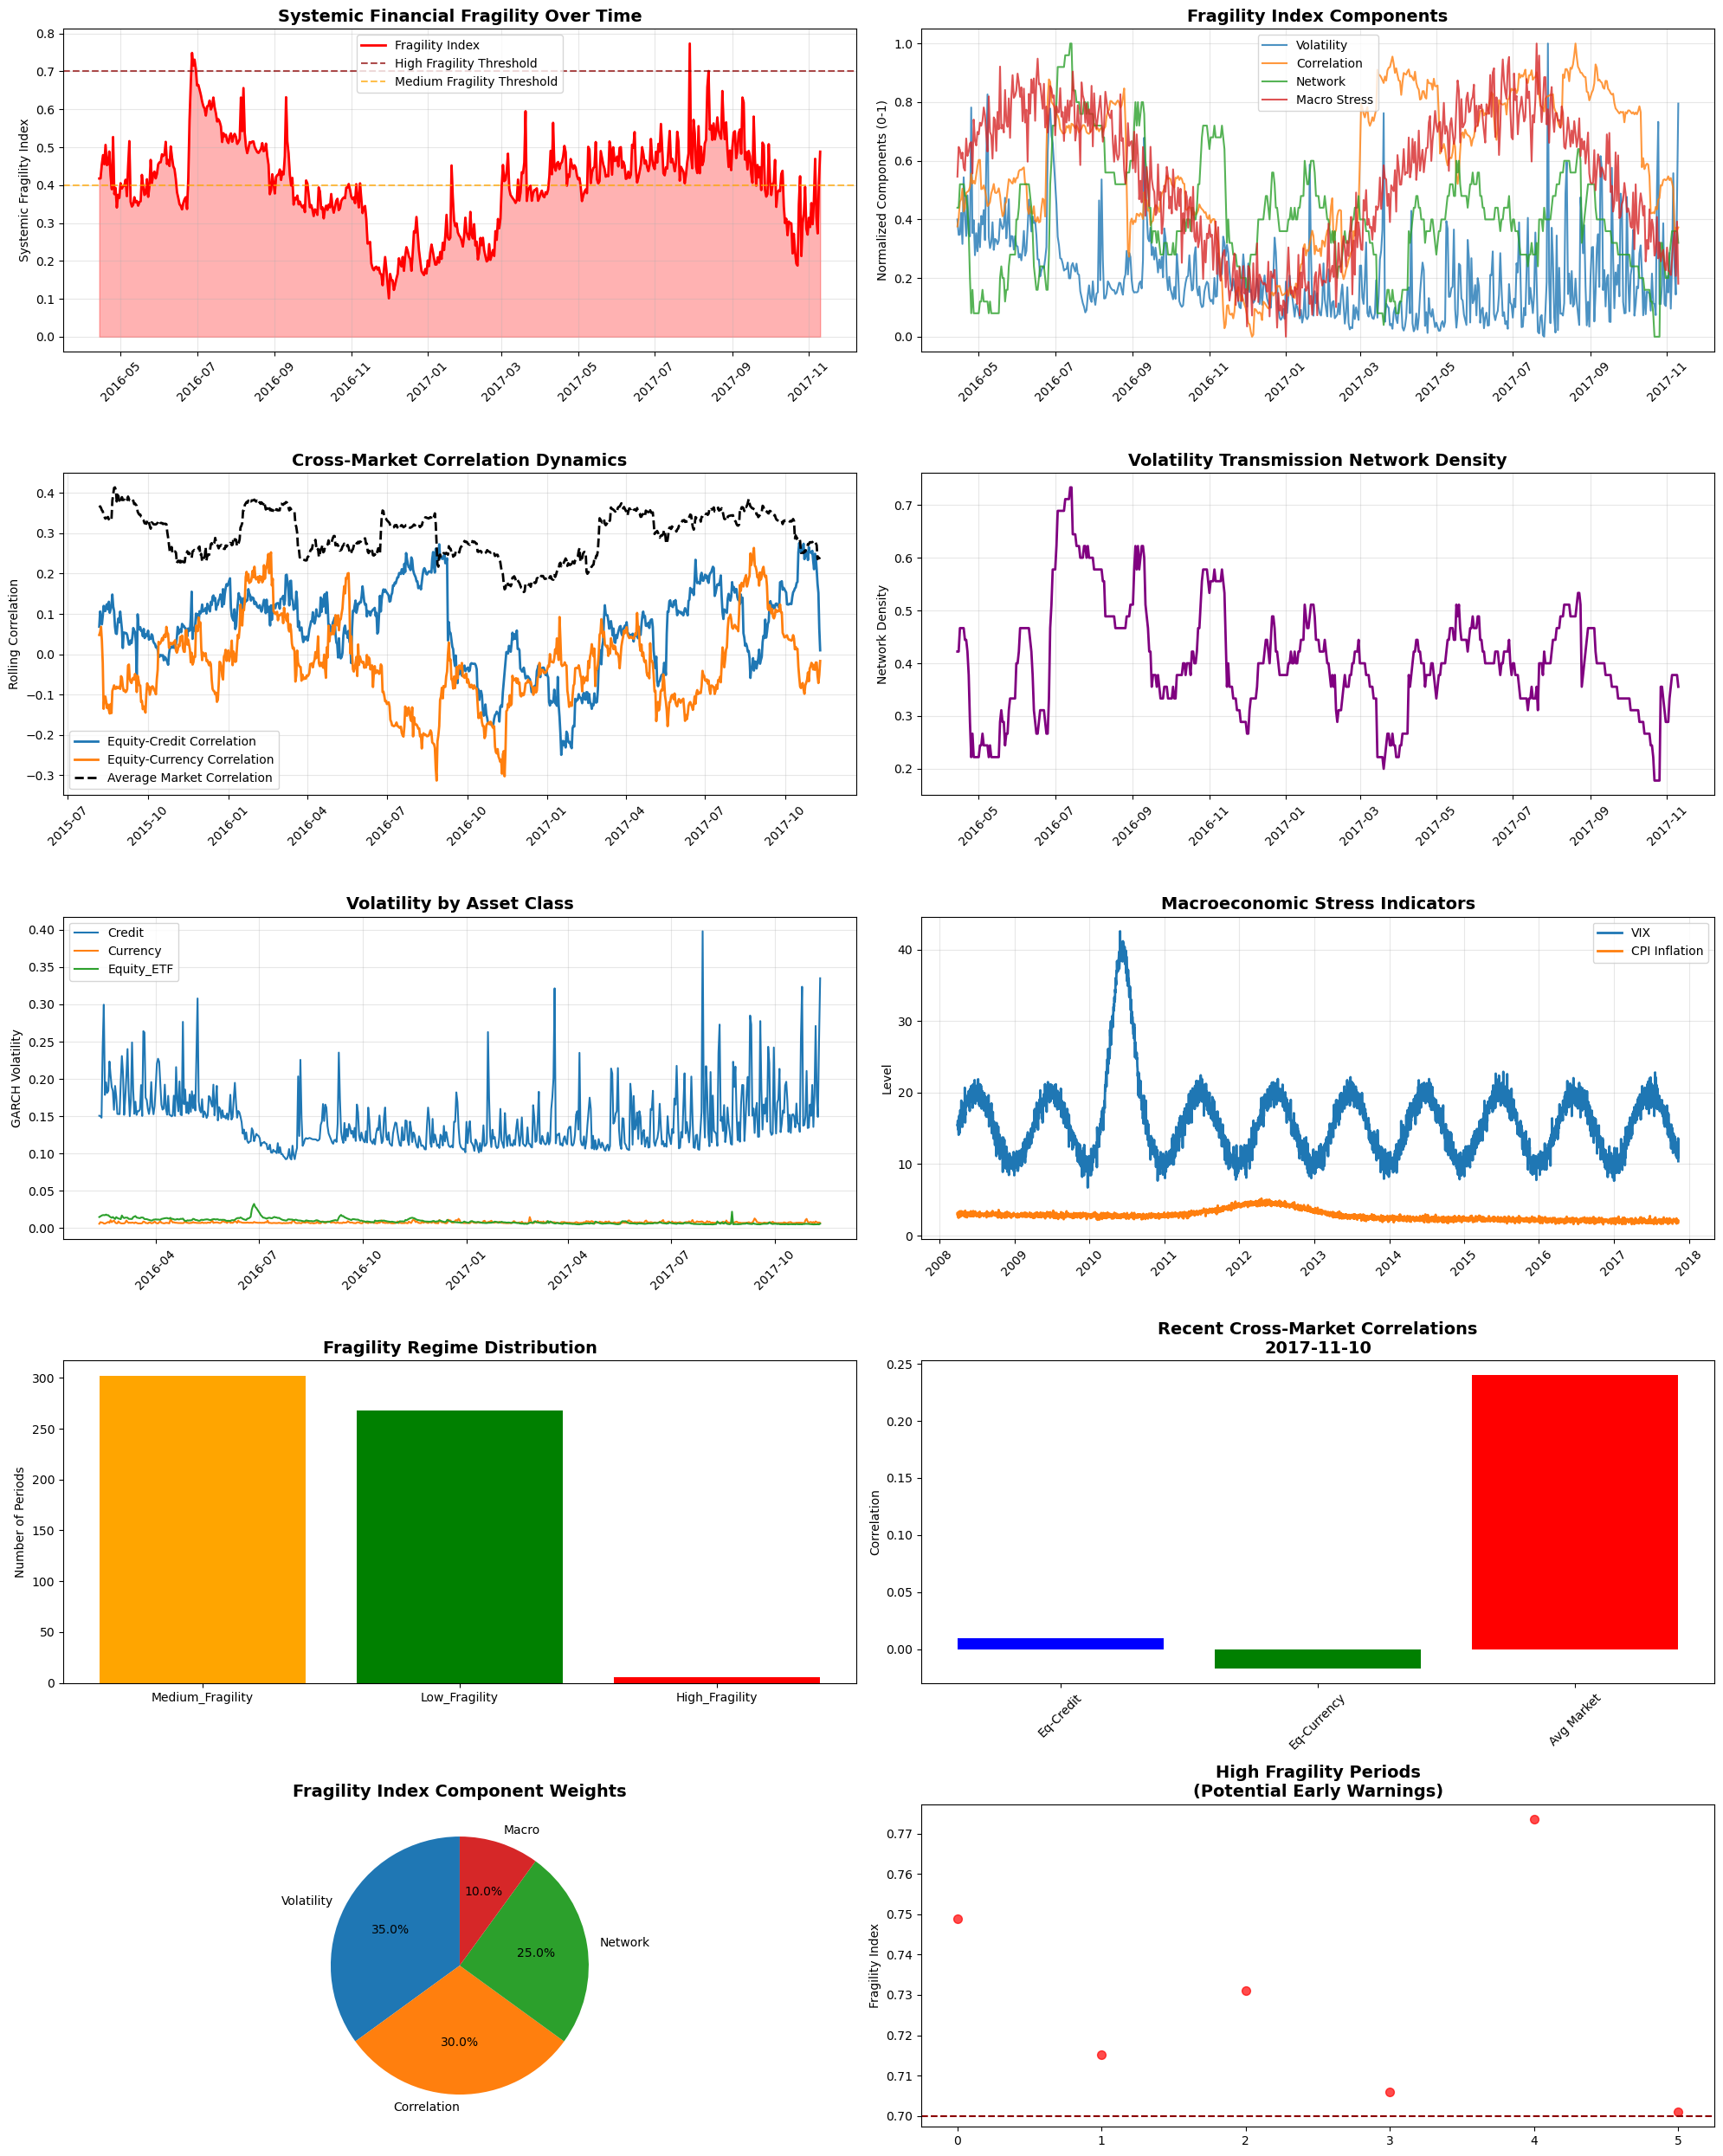


📈 SYSTEMIC FRAGILITY ANALYSIS REPORT

📊 KEY STATISTICS:
   • Average Fragility Index: 0.402
   • Maximum Fragility Index: 0.774
   • High Fragility Periods: 6 (1.0%)
   • Analysis Period: 2016-04-14 to 2017-11-10

🎯 FRAGILITY REGIMES:
   • Medium_Fragility: 302 periods (52.4%)
   • Low_Fragility: 268 periods (46.5%)
   • High_Fragility: 6 periods (1.0%)

🔍 CURRENT ASSESSMENT:
   • Current Fragility Index: 0.488
   • Current Regime: Medium_Fragility
   🔶 CAUTION: Elevated fragility levels detected

📈 DOMINANT FRAGILITY DRIVER:
   • Primary Contributor: Volatility
   • Volatility: 0.795
   • Correlation: 0.373
   • Network: 0.320
   • Macro Stress: 0.181

💡 KEY INSIGHTS:
   • Rising cross-market correlations often precede systemic stress
   • High network density indicates increased volatility transmission risk
   • Fragility tends to accumulate before manifesting in market drawdowns
   • Multi-asset analysis provides earlier warnings than single-market views

✅ SYSTEMIC FRAGILITY ANALY

In [12]:
# MAIN EXECUTION
# =============================================================================

def main():
    """
    Main execution function for Systemic Fragility Analysis
    """
    print("🚀 INITIATING SYSTEMIC FRAGILITY ANALYSIS")
    print("="*70)
    
    # Step 1: Extract and load data
    if not os.path.exists(Config.EXTRACT_PATH):
        print("📦 Extracting market data...")
        with zipfile.ZipFile(Config.ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(Config.EXTRACT_PATH)
    
    # Step 2: Load multi-asset data
    asset_data = load_data_simple(Config.EXTRACT_PATH)
    
    if not asset_data:
        print("❌ No data loaded. Exiting.")
        return
    
    # Step 3: Get date range
    all_dates = []
    for asset_df in asset_data.values():
        all_dates.extend(asset_df['Date'].tolist())
    
    start_date = min(all_dates)
    end_date = max(all_dates)
    
    print(f"\n📅 Analysis Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
    
    # Step 4: Prepare returns data
    returns_data = prepare_returns_data(asset_data, (start_date, end_date))
    
    if returns_data.empty:
        print("❌ No returns data prepared. Exiting.")
        return
    
    # Step 5: Compute GARCH volatilities
    volatility_data = compute_cross_asset_volatilities(returns_data)
    
    # Step 6: Calculate rolling correlations
    correlation_data = calculate_rolling_correlations(returns_data)
    
    # Step 7: Build volatility network
    network_data = build_volatility_network(volatility_data, returns_data)
    
    # Step 8: Generate macroeconomic data
    macro_data = create_macroeconomic_data(start_date, end_date)
    
    # Step 9: Compute Systemic Fragility Index
    fragility_data = compute_systemic_fragility_index(
        volatility_data, correlation_data, network_data, macro_data
    )
    
    if fragility_data.empty:
        print("❌ Could not compute fragility index. Exiting.")
        return
    
    # Step 10: Create visualizations and report
    create_comprehensive_visualizations(
        returns_data, volatility_data, correlation_data,
        network_data, fragility_data, macro_data
    )
    
    # Step 11: Generate analysis report
    generate_analysis_report(fragility_data, returns_data)
    
    print("\n" + "="*70)
    print("✅ SYSTEMIC FRAGILITY ANALYSIS COMPLETE")
    print("="*70)
    
    return {
        'returns_data': returns_data,
        'volatility_data': volatility_data, 
        'correlation_data': correlation_data,
        'network_data': network_data,
        'fragility_data': fragility_data,
        'macro_data': macro_data
    }

# Execute the analysis
if __name__ == "__main__":
    results = main()

### INTERPRETATION GUIDE

**Reading the Fragility Index**
- 0.0-0.4: Normal conditions - proceed with standard strategies
- 0.4-0.7: Elevated fragility - increase monitoring, consider reducing risk
- 0.7-1.0: High fragility - implement defensive measures, prepare for stress

**Component Analysis**
- Which driver dominates? Volatility vs. correlation vs. network effects
- Regime transitions: How does the system move between stability and fragility?
- Persistence patterns: Do fragility regimes cluster in time?

**Strategic Implications**
- Diversification efficacy varies by fragility regime
- Hedging costs may rise during high fragility periods
- Liquidity assumptions should account for systemic conditions

### CONCLUSION: FROM PRICE FORECASTING TO SYSTEMIC RISK ASSESSMENT

This framework represents a paradigm shift from traditional market analysis:

Traditional Approach: "Where will prices go?"
Systemic Approach: "How fragile is the financial system?"

By focusing on volatility transmission, cross-market linkages, and composite fragility scoring, we move beyond predicting individual asset movements to understanding the underlying stability of the entire financial ecosystem.

The analysis provides actionable insights for:

- Risk managers monitoring systemic exposures
- Portfolio managers adjusting to changing market structures
- Policy makers concerned with financial stability
- Researchers studying market interconnectedness

This is the difference between watching individual trees and understanding the health of the entire forest ecosystem.